In [ ]:
import numpy as np
import scipy.signal as signal
from IPython.display import display, Math

# System parameters
m_c = 1.0  # Cart mass (kg)
m_p = 0.1  # Pendulum mass (kg)
l = 0.5    # Pendulum length (m)
g = 9.8    # Gravity (m/s^2)

# State-space matrices
A = np.array([[0, 1, 0, 0],
              [0, 0, m_p * g / (m_c + m_p), 0],
              [0, 0, 0, 1],
              [0, 0, m_p * g / (l * (m_c + m_p)), 0]])

B = np.array([[0],
              [1 / (m_c + m_p)],
              [0],
              [1 / (l * (m_c + m_p))]])
# C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
# D = np.array([[0], [0]])
C = np.eye(4) # Full State Feedback
D = np.zeros((C.shape[0], B.shape[1]))
# Define the sample time for discretization
dt = 0.001  # Sampling time (seconds)

# Discretize the system using Zero-Order Hold (ZOH) method
system_zoh = signal.cont2discrete((A, B, C, D), dt, method='zoh')

# Unpack the system_zoh tuple properly
A_d, B_d, C_d, D_d, _ = system_zoh  # The last element is the sample time, which we don't need

# Compute the discrete-time transfer functions for cart position and pendulum angle
G_X_num, G_X_den = signal.ss2tf(A_d, B_d, C_d, D_d)  # Cart position transfer function
G_theta_num, G_theta_den = signal.ss2tf(A_d, B_d, C_d[1], D_d[1])  # Pendulum angle transfer function

# Assuming H(z^{-1}) as identity (or some noise model transfer function)
H = np.array([1, 0])  # Identity for noise transfer (assuming no significant noise model)


# Print LaTeX formatted output
X_latex = f"X_t = G_{{X}}(z^{{-1}}) U_t + H(z^{{-1}}) N_t"
theta_latex = f"\\theta_t =  G_{{\\theta}}(z^{{-1}}) U_t + H(z^{{-1}}) N_t"
# Print the system in the required form
print("Cart Position:")
display(Math(X_latex))
print(f"G_X(z^{-1}) = {G_X_num} / {G_X_den}")
print(f"H(z^{-1}) = {H}\n")

print("Pendulum Angle :")
display(Math(theta_latex))
print(f"G_theta(z^{-1}) = {G_theta_num} / {G_theta_den}")
print(f"H(z^{-1}) = {H}")

Cart Position:


<IPython.core.display.Math object>

G_X(z^-1) = [[ 0.00000000e+00  4.54545522e-07 -4.54545523e-07 -4.54545521e-07
   4.54545522e-07]
 [ 0.00000000e+00  9.09091179e-04 -2.72727354e-03  2.72727354e-03
  -9.09091179e-04]
 [ 0.00000000e+00  9.09091043e-07 -9.09091043e-07 -9.09091045e-07
   9.09091045e-07]
 [ 0.00000000e+00  1.81818236e-03 -5.45454707e-03  5.45454707e-03
  -1.81818236e-03]] / [ 1.         -4.00000178  6.00000356 -4.00000178  1.        ]
H(z^-1) = [1 0]

Pendulum Angle :


<IPython.core.display.Math object>

G_theta(z^-1) = [[ 0.          0.00090909 -0.00272727  0.00272727 -0.00090909]] / [ 1.         -4.00000178  6.00000356 -4.00000178  1.        ]
H(z^-1) = [1 0]


In [15]:
import control as ctrl
G = []
for i in range(len(G_X_num)):      
    G.append(ctrl.TransferFunction(G_X_num[i], G_X_den))
    print(G[i])

<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


4.545e-07 s^3 - 4.545e-07 s^2 - 4.545e-07 s + 4.545e-07
-------------------------------------------------------
             s^4 - 4 s^3 + 6 s^2 - 4 s + 1

<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.0009091 s^3 - 0.002727 s^2 + 0.002727 s - 0.0009091
-----------------------------------------------------
            s^4 - 4 s^3 + 6 s^2 - 4 s + 1

<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


9.091e-07 s^3 - 9.091e-07 s^2 - 9.091e-07 s + 9.091e-07
-------------------------------------------------------
             s^4 - 4 s^3 + 6 s^2 - 4 s + 1

<TransferFunction>: sys[8]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.001818 s^3 - 0.005455 s^2 + 0.005455 s - 0.001818
---------------------------------------------------
           s^4 - 4 s^3 + 6 s^2 - 4 s + 1



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      204
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       81

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       39
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6252331e+03 5.40e+00 3.97e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

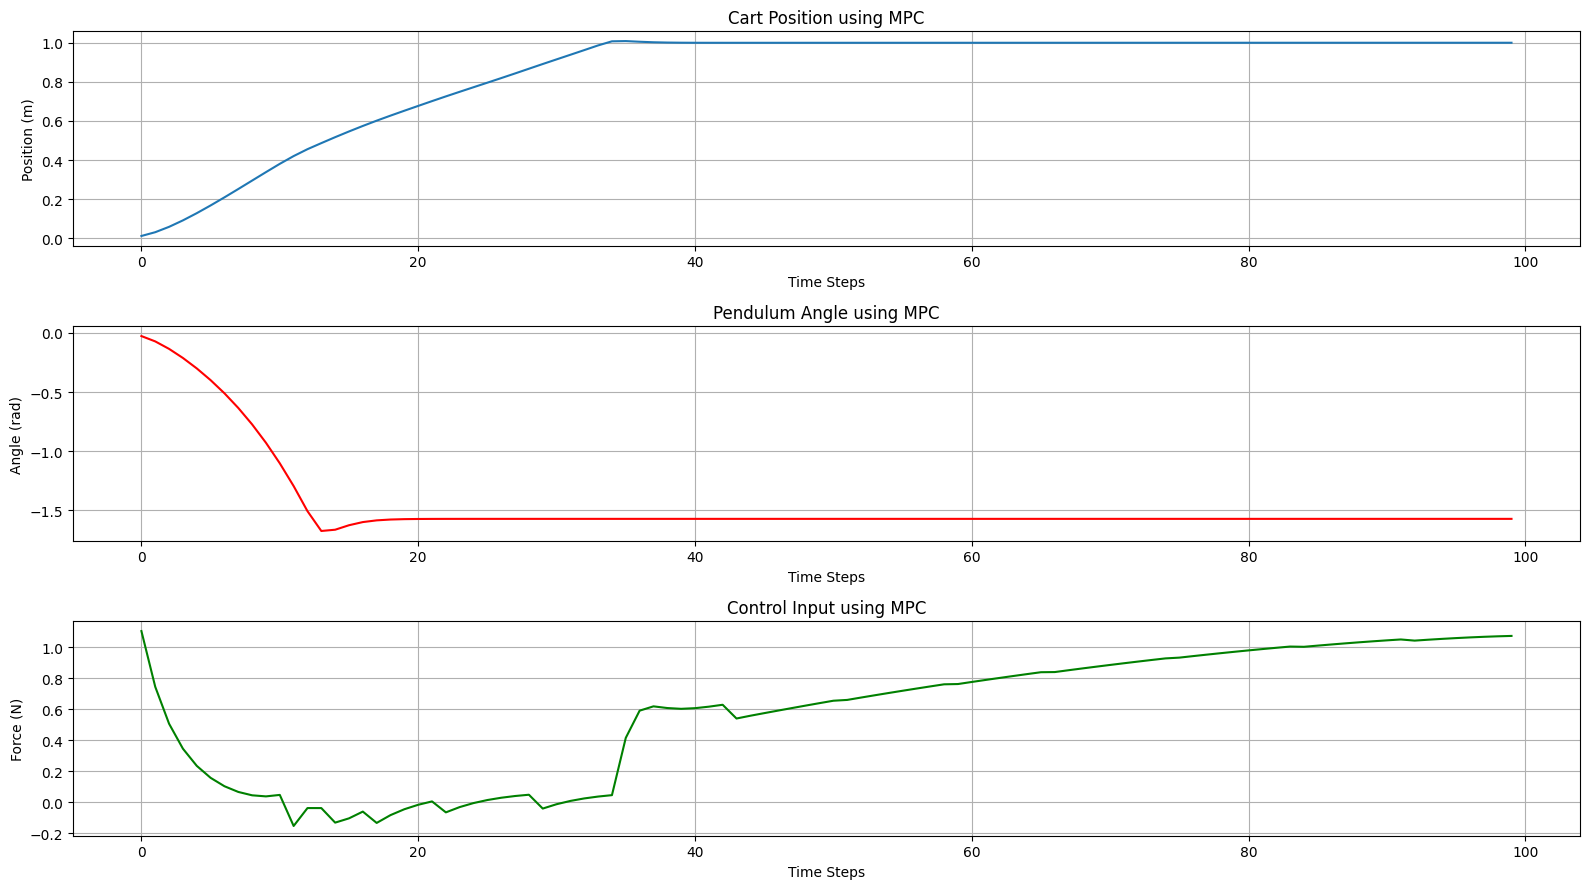

In [18]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import MX, vertcat, Function, sum1
# Seed
np.random.seed(99)
# Create cost terms (LQR-like penalties)
Q = np.diag([1, 50, 0, 0])  # Penalize cart position and velocity more
R = np.array([[0.1]])        # Penalize control effort
N = 20  # Prediction horizon length

# Define the moving window LQR function manually using do_mpc
def setup_mpc_model(A_mat, B_mat):
    """
    Set up the MPC model using the do_mpc package
    System dynamics (dx/dt = Ax + Bu)
    """
    # Define the model for the system using do_mpc
    model_type = 'discrete' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Define state and control variables (4 states, 1 control input)
    x = model.set_variable('_x', 'x', (A_mat.shape[0], 1))
    u = model.set_variable('_u', 'u', (1, 1))

    # State equations: dx/dt = A*x + B*u
    dxdt = A_mat @ x + B_mat @ u

    # Define the model dynamics (continuous time)
    model.set_rhs('x', dxdt)
    model.setup()
    return model

# Define the cost function (LQR-like)
def setup_mpc_controller(model, Q, R, N, x_ref):
    """
    Set up the cost function for MPC using do_mpc
    """
    mpc = do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_robust': 0,
        'n_horizon': N,
        't_step': dt,
        'state_discretization': 'discrete',
        'store_full_solution':True,
        # Use MA27 linear solver in ipopt for faster calculations:
        #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
    }
    mpc.set_param(**setup_mpc)
    # Define the cost function (stage cost)
    x = model.x['x'] - x_ref
    u = model.u['u']

    # Quadratic stage cost: x'Qx + u'Ru
    stage_cost = x.T @ Q @ x
    # Set objective function
    mterm = sum1(x.T @ Q @ x)   # Terminal cost (state-dependent)
    lterm = sum1(stage_cost)    # Stage cost (state + control dependent)

    # Set the objective function with correct inputs
    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u=R[0][0])  # Control effort penalty

    # Input constraints (optional)
    mpc.bounds['lower', '_u', 'u'] = -3
    mpc.bounds['upper', '_u', 'u'] = 3


    max_x = np.array([1, np.inf, np.inf, np.inf])
    mpc.bounds['lower', '_x', 'x'] = -max_x
    mpc.bounds['upper', '_x', 'x'] = max_x


    # Setup controller
    mpc.setup()
    return mpc

# Set a random initial guess within bounds for the MPC optimization variables
def set_bounded_initial_guess(mpc, model, x0, u0=10):
    """
    Set a random initial guess for the MPC optimization variables within bounds.
    """
    # Initial control input guess
    # e = np.ones([model.n_u,1])
    # u0 = np.random.uniform(-3*e,3*e) # Values between -5 and +5 for control input

    # Set the initial guesses
    mpc.x0 = x0
    mpc.u0 = u0
    mpc.set_initial_guess()

def wrap_angle(theta):
    """
    Wrap the angle theta to the range [-pi, pi].
    """
    return (theta + np.pi) % (2 * np.pi) - np.pi

# Set up the optimization problem using do_mpc
model = setup_mpc_model(A,B)
x_ref = np.array([[0], [np.pi/2], [0], [0]])  # Desired state: cart at 0, pendulum upright at rest
# Set the objective function
mpc = setup_mpc_controller(model, Q, R, N, x_ref)
# Apply the bounded initial guess


# Initialize the gym environment
env = gym.make('InvertedPendulum-v5', render_mode='human')
state, _ = env.reset(seed=123)

set_bounded_initial_guess(mpc, model, x0=np.array(state).reshape(-1, 1))

estimator = do_mpc.estimator.StateFeedback(model)
# Data storage for plotting
cart_position = []
pendulum_angle = []
input_control = []
# Simulation loop
for episode in range(1):
    done = False
    total_reward = 0
    steps = 0

    while steps < 100:
        x = np.array(state).reshape(-1, 1)  # Current state as column vector

        # Make MPC step and get control input
        u = mpc.make_step(x)[0, 0]# Extract control input from the MPC solution
        # Apply control input and step environment
        state, reward, done, truncated, info = env.step([float(u)])  # Convert to scalar

        # Wrap the angle to ensure it is between -pi and pi
        # state[2] = wrap_angle(state[2])  # Assuming state[2] is the pendulum angle

        # Store results for plotting
        input_control.append(u)
        cart_position.append(state[0])  # Cart position
        pendulum_angle.append(state[1])  # Pendulum angle

        total_reward += reward
        steps += 1

    print(f"Episode {episode + 1} - Total Reward: {total_reward}")

env.close()
# Plot results after the simulation
plt.figure(figsize=(16, 9))

# Plot cart position
plt.subplot(3, 1, 1)
plt.plot(cart_position, label="Cart Position (X_t)")
plt.title("Cart Position using MPC")
plt.xlabel("Time Steps")
plt.ylabel("Position (m)")
plt.grid(visible=True)

# Plot pendulum angle
plt.subplot(3, 1, 2)
plt.plot(pendulum_angle, label="Pendulum Angle (θ_t)", color='r')
plt.title("Pendulum Angle using MPC")
plt.xlabel("Time Steps")
plt.ylabel("Angle (rad)")
plt.grid(visible=True)

# plot the control input
plt.subplot(3, 1, 3)
plt.plot(input_control, label="Control Input (U_t)", color='g')
plt.title("Control Input using MPC")
plt.xlabel("Time Steps")
plt.ylabel("Force (N)")
plt.grid(visible=True)


plt.tight_layout()
plt.show()

In [145]:
# Seed
np.random.seed(99)
estimator = do_mpc.estimator.StateFeedback(model)
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.000001)
simulator.setup()
# Initial state
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

In [146]:
%%capture
for k in range(50):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

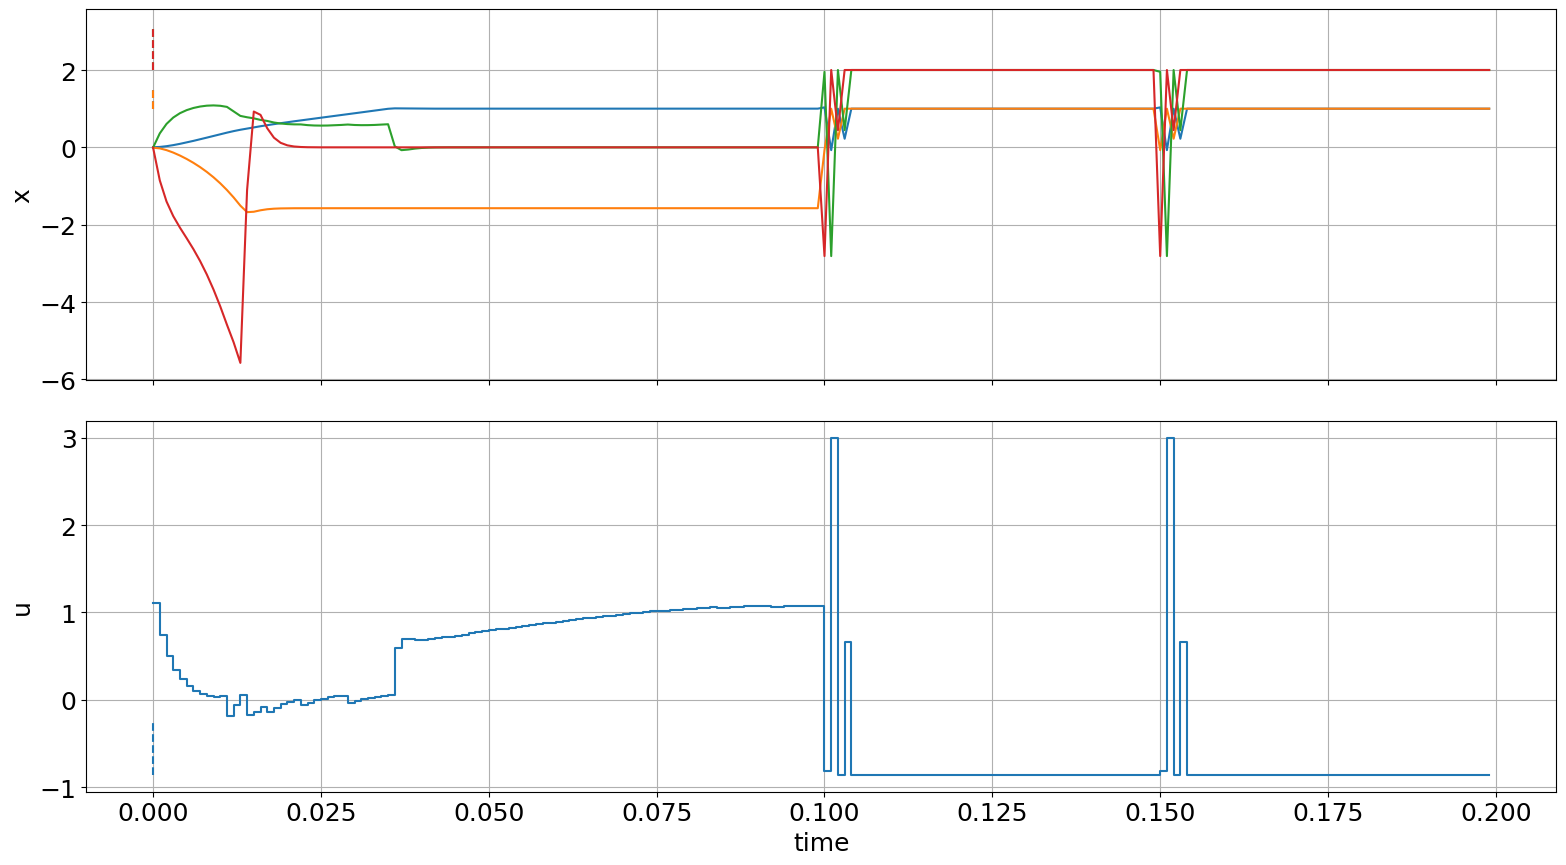

In [153]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

In [ ]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

pendulum -v1

In [5]:
import numpy as np
import scipy.signal as signal
from IPython.display import display, Math

# Parameters
m = 1.0      # Mass of pendulum (kg)
l = 1.0      # Length of pendulum (m)
b = 0.1      # Damping coefficient (N.m.s)
g = 9.81     # Gravitational acceleration (m/s^2)

# State-space matrices
A = np.array([[0, 1],
              [-g / l, -b / (m * l**2)]])
B = np.array([[0],
              [1 / (m * l**2)]])
C = np.eye(2)
D = np.zeros((2, 1))

# Define the sample time for discretization
dt = 0.1  # Sampling time (seconds)

# Discretize the system using Zero-Order Hold (ZOH) method
system_zoh = signal.cont2discrete((A, B, C, D), dt, method='zoh')

# Unpack the system_zoh tuple properly
A_d, B_d, C_d, D_d, _ = system_zoh  # The last element is the sample time, which we don't need

# Compute the discrete-time transfer functions for cart position and pendulum angle
G_X_num, G_X_den = signal.ss2tf(A_d, B_d, C_d[0], D_d[0])  # Cart position transfer function
G_theta_num, G_theta_den = signal.ss2tf(A_d, B_d, C_d[1], D_d[1])  # Pendulum angle transfer function

# Assuming H(z^{-1}) as identity (or some noise model transfer function)
H = np.array([1, 0])  # Identity for noise transfer (assuming no significant noise model)


# Print LaTeX formatted output
X_latex = f"X_t = G_{{X}}(z^{{-1}}) U_t + H(z^{{-1}}) N_t"
theta_latex = f"\\theta_t =  G_{{\\theta}}(z^{{-1}}) U_t + H(z^{{-1}}) N_t"
# Print the system in the required form
print("Cart Position:")
display(Math(X_latex))
print(f"G_X(z^{-1}) = {G_X_num} / {G_X_den}")
print(f"H(z^{-1}) = {H}\n")

print("Pendulum Angle :")
display(Math(theta_latex))
print(f"G_theta(z^{-1}) = {G_theta_num} / {G_theta_den}")
print(f"H(z^{-1}) = {H}")

Cart Position:


<IPython.core.display.Math object>

G_X(z^-1) = [[0.         0.0049428  0.00492629]] / [ 1.         -1.89323407  0.99004983]
H(z^-1) = [1 0]

Pendulum Angle :


<IPython.core.display.Math object>

G_theta(z^-1) = [[ 0.          0.09788277 -0.09788277]] / [ 1.         -1.89323407  0.99004983]
H(z^-1) = [1 0]


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import MX, vertcat, sin, cos, sum1

# Seed
np.random.seed(99)

# Pendulum parameters
m = 1.0     # Mass (kg)
l = 1.0     # Length (m)
b = 0.1     # Damping coefficient (N.m.s)
g = 9.81    # Gravitational acceleration (m/s^2)

# Cost terms (LQR-like penalties)
Q = np.diag([1, 0.1, 0.001])  # Penalize angle and velocity
R = np.array([[0.1]])   # Penalize control effort
N = 20  # Prediction horizon length

# Create do-mpc model
def setup_mpc_model():
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # Define state variables: cos(theta), sin(theta), theta_dot
    x = model.set_variable(var_type='_x', var_name='x', shape=(3, 1))
    u = model.set_variable(var_type='_u', var_name='u', shape=(1, 1))

    # Extract states
    cos_theta, sin_theta, theta_dot = x[0], x[1], x[2]

    # Calculate the angle theta
    theta = np.arctan2(sin_theta, cos_theta)

    # Nonlinear dynamics of the pendulum
    theta_ddot = (-3 * g / (2 * l) * sin(theta) - b * theta_dot + 3 / (m * l**2) * u)

    # Define state equations
    model.set_rhs('x', vertcat(
        theta_dot * (-sin_theta),  # cos(theta) dynamics
        theta_dot * cos_theta,    # sin(theta) dynamics
        theta_ddot                # angular acceleration
    ))

    model.setup()
    return model

# Define the cost function
def setup_mpc_controller(model, Q, R, N):
    mpc = do_mpc.controller.MPC(model)
    # MPC Parameters
    setup_mpc = {
        'n_horizon': 7,                # Prediction horizon
        't_step': 0.1,                  # Time step
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'store_full_solution': True
    }
    mpc.set_param(**setup_mpc)

    x_ref = np.array([[1], [0], [0]])  # Desired state: pendulum upright at rest
    x = model.x['x'] - x_ref
    u = model.u['u']
    theta = np.arctan2(x[1], x[0])
    # Quadratic cost: angle near zero and low control effort

    # Define objective (cost function)
    mterm = sum1(x)
    lterm = (theta**2 + 0.1 * x[2]**2 + 0.001 * u**2)

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u=0.1)  # Regularization for smoother control

    # stage_cost = x.T @ Q @ x + u.T @ R @ u
    # mterm = x.T @ Q @ x
    # lterm = stage_cost

    # mpc.set_objective(mterm=mterm, lterm=lterm)

    # Input constraints (torque limits)
    mpc.bounds['lower', '_u', 'u'] = -2.0
    mpc.bounds['upper', '_u', 'u'] = 2.0

    x_max = np.array([1, 1, 8])
    mpc.bounds['lower', '_x', 'x'] = -x_max
    mpc.bounds['upper', '_x', 'x'] = x_max

    # State constraints (optional)
    mpc.setup()
    return mpc

# Set random initial guess within bounds
def set_bounded_initial_guess(mpc, x0):
    mpc.x0 = x0
    mpc.set_initial_guess()

# Set up the model and MPC
model = setup_mpc_model()
mpc = setup_mpc_controller(model, Q, R, N)


# Initialize Gym environment
env = gym.make("Pendulum-v1", g=g)
state, _ = env.reset(seed=123)
set_bounded_initial_guess(mpc, state)


# Data storage
theta_list = []
torque_list = []
sin_list = []
cos_list = []
# Simulation loop
for step in range(200):
    cos_theta, sin_theta, theta_dot = state
    theta = np.arctan2(sin_theta, cos_theta)

    # MPC step
    x = np.array([[cos_theta], [sin_theta], [theta_dot]])
    u = -mpc.make_step(x)[0,0]

    # Apply control input
    state, reward, done, _, _ = env.step([float(u)])

    # Store results
    cos_list.append(cos_theta)
    sin_list.append(sin_theta)
    theta_list.append(theta)
    torque_list.append(float(u))

env.close()

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(theta_list, label="Pendulum Angle (rad)")
plt.title("Pendulum Angle Control using MPC")
plt.xlabel("Time Steps")
plt.ylabel("Angle (rad)")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(torque_list, label="Control Torque (Nm)", color='r')
plt.title("Control Torque")
plt.xlabel("Time Steps")
plt.ylabel("Torque (Nm)")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(cos_list, label="cos(theta)", color='g')
plt.title("cos(theta)")
plt.xlabel("Time Steps")
plt.ylabel("cos(theta)")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(sin_list, label="sin(theta)", color='b')
plt.title("sin(theta)")
plt.xlabel("Time Steps")
plt.ylabel("sin(theta)")
plt.grid(True)

plt.tight_layout()
plt.show()


d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      311
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      111

Total number of variables............................:      103
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       79
                     variables with only upper bounds:        0
Total number of equality constraints.................:       87
Total number of inequality c

In [ ]:
import numpy as np
import cv2

from sims.InvertedPendulum import InvertedPendulum

from scipy.integrate import solve_ivp
import control


class MyLinearizedSystem:
    def __init__(self):
        g = 9.8
        L = 1.5
        m = 1.0
        M = 5.0
        d1 = 1.0
        d2 = 0.5

        # Pendulum up (linearized eq)
        _q = (m+M) * g / (M*L)
        self.A = np.array([
            [0, 1, 0, 0],
            [0, -d1, -g*m/M, 0],
            [0, 0, 0, 1.],
            [0, d1/L, _q, -d2]
        ])

        self.B = np.expand_dims(np.array([0, 1.0/M, 0., -1/(M*L)]), 1)  # 4x1

    def compute_K(self, desired_eigs=[-0.1, -0.2, -0.3, -0.4]):
        print('[compute_K] desired_eigs=', desired_eigs)
        self.K = control.place(self.A, self.B, desired_eigs)

    def get_K(self):
        return self.K


# Global Variables
ss = MyLinearizedSystem()

# Eigen Values set by LQR
Q = np.diag([1, 1, 1, 1.])
R = np.diag([1.])
# K : State feedback for stability
# S : Solution to Riccati Equation
# E : Eigen values of the closed loop system
K, S, E = control.lqr(ss.A, ss.B, Q, R)
ss.compute_K(desired_eigs=E)  # Arbitrarily set desired eigen values


# This will be our LQR Controller.
def u(t, y):
    u_ = -np.matmul(ss.K, y - np.array([0, 0, np.pi/2., 0]))  # This was important
    print('u()', 't=', t, 'u_=', u_)
    return u_[0]


# Pendulum and cart system (non-linear eq)
def y_dot(t, y):
    g = 9.8  # Gravitational Acceleration
    L = 1.5  # Length of pendulum

    m = 1.0  # mass of bob (kg)
    M = 5.0  # mass of cart (kg)

    d1 = 1.0
    d2 = 0.5

    x_ddot = u(t, y) - m*L*y[3]*y[3] * np.cos(y[2]) + m*g*np.cos(y[2]) * np.sin(y[2])
    x_ddot = x_ddot / (M + m - m * np.sin(y[2]) * np.sin(y[2]))

    theta_ddot = -g/L * np.cos(y[2]) - np.sin(y[2]) / L * x_ddot

    damping_x = -d1 * y[1]
    damping_theta = -d2 * y[3]

    return [y[1], x_ddot + damping_x, y[3], theta_ddot + damping_theta]


# Solve the system
sol = solve_ivp(y_dot, [0, 20], [0.0, 0., np.pi/2 + 0.01, 0.], t_eval=np.linspace(0, 20, 100))

syst = InvertedPendulum()

for i, t in enumerate(sol.t):
    rendered = syst.step([sol.y[0, i], sol.y[1, i], sol.y[2, i], sol.y[3, i]], t)
    cv2.imshow('im', rendered)
    cv2.moveWindow('im', 100, 100)

    if cv2.waitKey(0) == ord('q'):
        break


[compute_K] desired_eigs= [-3.17509106 -2.48883218 -0.81949749 -0.20177408]
u() t= 0.0 u_= [1.69417376]
u() t= 2.8419469493403014e-05 u_= [1.69404411]
u() t= 0.0005683893898680603 u_= [1.69158075]
u() t= 0.0008525840848020904 u_= [1.69028401]
u() t= 0.0022735575594722414 u_= [1.68380024]
u() t= 0.002526175066080268 u_= [1.68264762]
u() t= 0.0028419469493403014 u_= [1.68120655]
u() t= 0.0028419469493403014 u_= [1.6812063]
u() t= 0.008525840848020903 u_= [1.65526697]
u() t= 0.011367787797361206 u_= [1.64227916]
u() t= 0.025577522544062713 u_= [1.57750421]
u() t= 0.028103697610142978 u_= [1.56616873]
u() t= 0.031261416442743314 u_= [1.5517541]
u() t= 0.031261416442743314 u_= [1.55149488]
u() t= 0.0666470118841282 u_= [1.39019685]
u() t= 0.08433980960482065 u_= [1.31074725]
u() t= 0.17280379820828284 u_= [0.95462878]
u() t= 0.18853072951556504 u_= [0.94025946]
u() t= 0.20818939364966776 u_= [0.86292515]
u() t= 0.20818939364966776 u_= [0.79273429]
u() t= 0.25536640935091304 u_= [0.61052419]

: 

In [ ]:
pip install 

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.
